# IPEO Project: Hurricane Damage Detection with Deep Learning

# 1. Setup

### 1.1 Install dependencies

In [40]:
!pip install -U -q torch torchvision matplotlib tqdm gdown 

# DINO Classification Inference

In [41]:
!pip install transformers

In [42]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import accuracy_score, f1_score
from Dino.dataset import Preprocessing_Transforms
from Dino.models import extract_dino_features, classifier


### Display Sample Test Image

Class:  damage


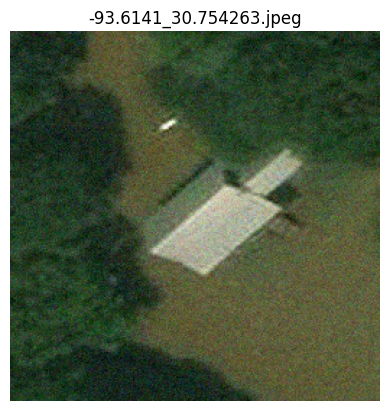

Class:  no_damage


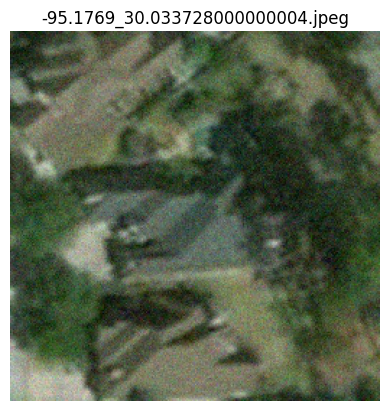

Loading cached features from Dino\dinocache\test.pt


In [43]:
## Test Sample Image
import os
from PIL import Image
import matplotlib.pyplot as plt

sample_test_dataset = "sample_test_set"

image_paths = []
classification = []
for root, dirs, files in os.walk(sample_test_dataset):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif")):
            image_paths.append(os.path.join(root, file))
            classification.append(root)

# Display images one by one

for i in range(len(image_paths)):
    img_path = image_paths[i]
    class_ = classification[i]
    print("Class: ", class_[16:])
    img = Image.open(img_path).convert("RGB")  # Ensure RGB
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()


sample_test_img_ds = datasets.ImageFolder(
    sample_test_dataset, transform=Preprocessing_Transforms
)

X_test, y_test = extract_dino_features(
    sample_test_dataset, Path("Dino/dinocache/test.pt")
)

test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=1)


In [44]:
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


test_dataset = "sample_test_set"

### Load Test Dataset
test_img_ds = datasets.ImageFolder(
    test_dataset, transform=Preprocessing_Transforms
)

X_test, y_test = extract_dino_features(
    test_img_ds, Path("Dino/dinocache/test_sample.pt")
)

test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


Extracting test_sample.pt: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s]


### Download Classifier from pretrained weights

In [45]:
MODEL_PATH = "Dino/dino_classifier.pth"

classifier.load_state_dict(
    torch.load(MODEL_PATH, map_location=DEVICE)
)
classifier.to(DEVICE)
classifier.eval()

Sequential(
  (0): Linear(in_features=384, out_features=256, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
)

### DINO performance on sample images

Note that the Calibration_Scaler is the temperature value that was derived in the notebook `IPEO project.ipynb`

In [46]:
import torch.nn.functional as F

dino_test_preds, dino_test_labels, dino_test_logits = [], [], []

Calibration_Scaler = 1.2403223514556885

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        p = classifier(x).argmax(1).cpu()
        dino_test_logits.append(classifier(x).cpu())
        dino_test_preds.extend(p.numpy())
        dino_test_labels.extend(y.numpy())


idx_to_class = {v: k for k, v in test_img_ds.class_to_idx.items()}


for i in range(len(dino_test_preds)):
    logits = dino_test_logits[0][i].unsqueeze(0)  # shape [1, num_classes]
    # Apply temperature scaling and softmax
    probs = F.softmax(logits / Calibration_Scaler, dim=1)[0]
    # Get probability of predicted class
    pred_class = dino_test_preds[i]
    
    prob = probs[pred_class].item()
    
    print(
        "Predicted a", idx_to_class[dino_test_labels[i]], 
        "sample as", idx_to_class[pred_class], 
        "with probability", round(prob, 4)
    )


Predicted a damage sample as damage with probability 0.9997
Predicted a no_damage sample as no_damage with probability 1.0
